# Introduction

The Proper Orthogonal Decomposition (POD) is equivalent to PCA. Conventionally, we refer to POD when analysing the dynamics of a time-dependent dataset.

In general, decomposing a time-dependent signal means decoupling the spatially-dependent part from the time-dependent one:
\begin{equation}
    X(\bar{r}, t) = \Phi(\bar{r}) \ \Sigma \ \Psi(t)^T
\end{equation}

The POD can be achieved by applying the Singular Value Decomposition:
\begin{equation}
    X(\bar{r}, t) = U(\bar{r}) \ \Sigma \ V(t)^T
\end{equation}



In [2]:
# In this cell we create the data matrix X for case f=10 Hz. The feature to analyse is the OH mass fraction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation 

path = '/Users/alberto/Documents/Teaching/ERCOFTAC/DMD_Peppe' # Path to the dataset 
timesteps = np.arange(0., 0.25, step=0.00025) # Number of timesteps 

# We load the first timestep to get the spatial coordinates
df_f10_0 = pd.read_csv(f'{path}/output.0', sep='\s+')
xyz = np.array(df_f10_0[['x[m](2)', 'y[m](3)', 'z[m](4)']])

n = xyz.shape[0] # Number of rows (cells)

X_f10 = np.load(f'{path}/X_f10.npy')
m = X_f10.shape[1] # Number of columns (timesteps)


In [3]:
# In this cell we remove the mean from the dataset and we apply the SVD to get the POD modes.

X0_f10 = np.zeros_like(X_f10)
mean = np.mean(X_f10, axis=1)

for i in range(m):
    X0_f10[:,i] = X_f10[:,i] - mean
    
U, S, Vt = np.linalg.svd(X_f10, full_matrices=False)
V = Vt.T

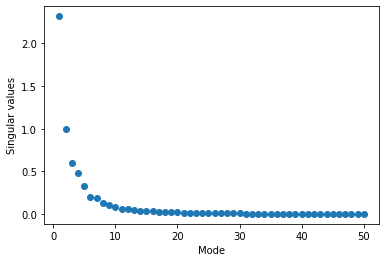

In [4]:
# In this cell we plot the first 50 singular values.

n_values = 50
plt.scatter(np.arange(1, n_values+1), S[:n_values])
plt.xlabel('Mode')
plt.ylabel('Singular values')
plt.show()

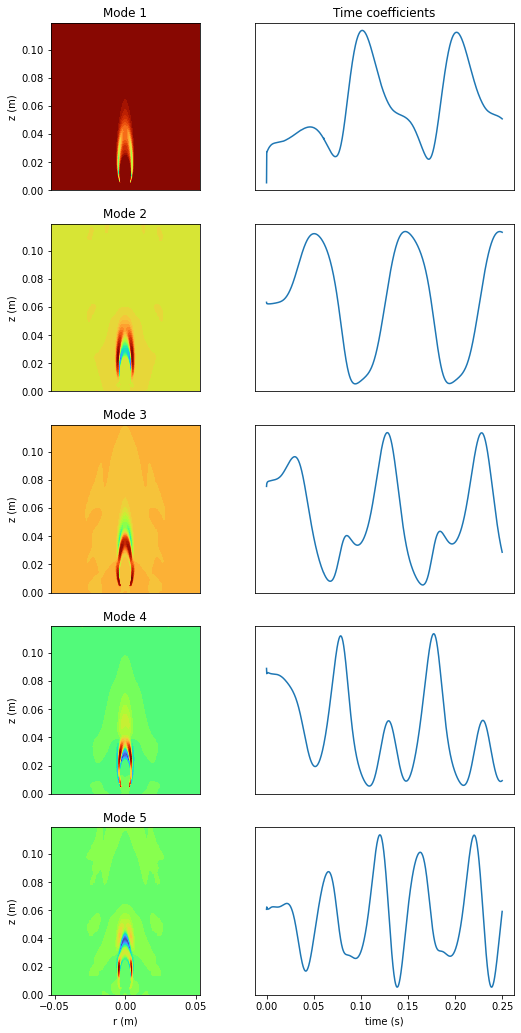

In [5]:
# In this cell we plot the first 5 modes and their temporal coefficients.

# Plotting utility
def plot_modes(r, z, U, V, n_modes, timesteps, filename=''):
    fig, axs = plt.subplots(nrows=n_modes, ncols=2, figsize=(8, n_modes*3))
    levels = 32
    
    r_mirror = np.concatenate((r, -r))
    z_mirror = np.concatenate((z, z))
    
    triang = tri.Triangulation(r_mirror, z_mirror)
    
    for i in range(n_modes):
        mode = np.concatenate((U[:,i], U[:,i]))
        axs[i,0].tricontourf(triang, mode, levels, cmap='turbo')
        axs[i,0].set_aspect('equal')
        axs[i,0].set_ylabel('z (m)')
        axs[i,0].set_ylim(bottom=0)
        axs[i,0].set_title(f'Mode {i+1}')
        
        if i < n_modes - 1:
            axs[i,0].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
            axs[i,1].tick_params(axis='x', which='both', bottom=False, labelbottom=False)
        else:
            axs[i,0].set_xlabel('r (m)')
            axs[i,1].set_xlabel('time (s)')
        
        time = V[:,i]
        axs[i,1].plot(timesteps, time)
        axs[i,1].tick_params(axis='y', which='both', left=False, labelleft=False)
        if i == 0:
            axs[i,1].set_title('Time coefficients')
                 
    # fig.tight_layout()
    fig.subplots_adjust(bottom=0.05, top=.95, left=0.05, right=.95, wspace=0.0, hspace=0.2)

    if filename != '':
        fig.savefig(filename, transparent=True, dpi=600, bbox_inches='tight')    
    
    plt.show()

n_modes = 5
plot_modes(xyz[:,0], xyz[:,2], U, V, n_modes, timesteps)